In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from os import listdir
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob
import cv2

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available:  0


In [2]:
# Dimensional reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
df =  pd.read_csv('df_t.csv')
df.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,brand,product_specifications,category,_lon_desc,cleaned_description,stop_removed_description,tokenized,lemmatized,lemmatize_joined,Nombre de mots après nettoyage
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,1420,features elegance polyester multicolor abstrac...,features elegance polyester multicolor abstrac...,"['features', 'elegance', 'polyester', 'multico...","['feature', 'elegance', 'polyester', 'multicol...",feature elegance polyester multicolor abstract...,141
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,444,specifications sathiyas cotton bath towel bath...,specifications sathiyas cotton bath towel bath...,"['specifications', 'sathiyas', 'cotton', 'bath...","['specifications', 'sathiyas', 'cotton', 'bath...",specifications sathiyas cotton bath towel bath...,55


In [28]:
path

'Images/'

In [29]:
df.category.sort_values().unique()

array(['Baby Care', 'Beauty and Personal Care', 'Computers',
       'Home Decor & Festive Needs', 'Home Furnishing',
       'Kitchen & Dining', 'Watches'], dtype=object)

In [30]:
df['category'].value_counts()

category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

In [31]:
df.groupby("category").count()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,overall_rating,brand,product_specifications,_lon_desc,cleaned_description,stop_removed_description,tokenized,lemmatized,lemmatize_joined,Nombre de mots après nettoyage
category,,,,,,,,,,,,,,,,,,,,,
Baby Care,150,150,150,150,150,150,149,149,150,150,...,150,134,150,150,150,150,150,150,150,150
Beauty and Personal Care,150,150,150,150,150,150,150,150,150,150,...,150,41,150,150,150,150,150,150,150,150
Computers,150,150,150,150,150,150,150,150,150,150,...,150,150,150,150,150,150,150,150,150,150
Home Decor & Festive Needs,150,150,150,150,150,150,150,150,150,150,...,150,148,149,150,150,150,150,150,150,150
Home Furnishing,150,150,150,150,150,150,150,150,150,150,...,150,150,150,150,150,150,150,150,150,150
Kitchen & Dining,150,150,150,150,150,150,150,150,150,150,...,150,79,150,150,150,150,150,150,150,150
Watches,150,150,150,150,150,150,150,150,150,150,...,150,10,150,150,150,150,150,150,150,150


In [38]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'category' column
df['category_encoded'] = label_encoder.fit_transform(df['category'])

In [39]:
list_labels = df.category.sort_values().unique()

In [46]:
def list_products_by_category(category_name):
    return df[df['category'] == category_name]['image'].to_list()

Baby Care


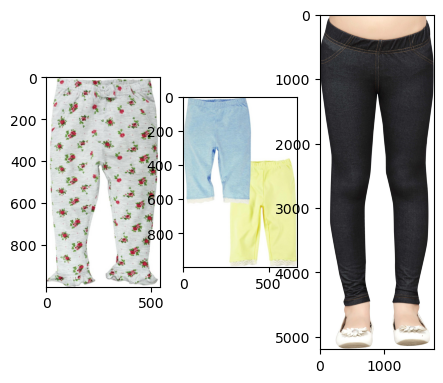

Beauty and Personal Care


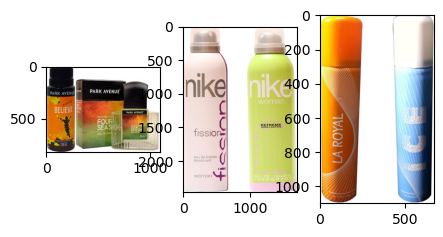

Computers


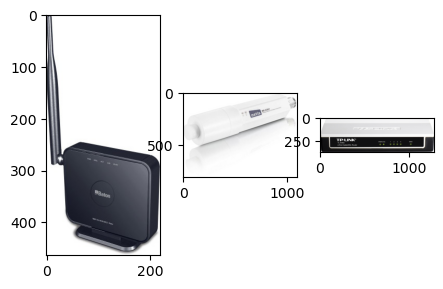

Home Decor & Festive Needs


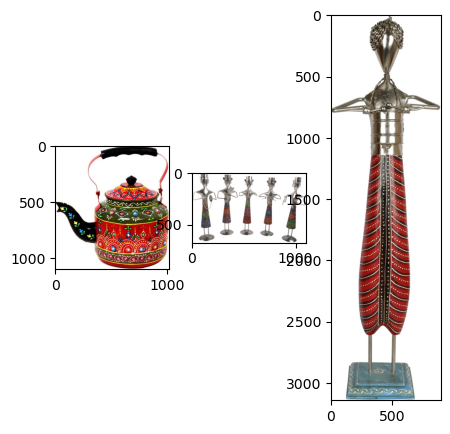

Home Furnishing


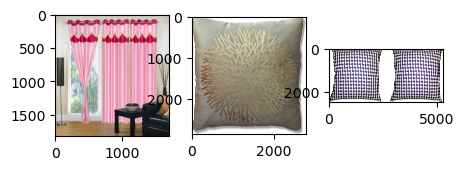

Kitchen & Dining


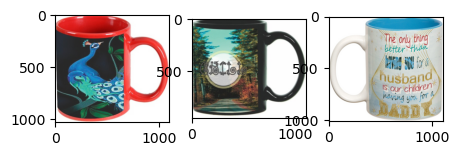

Watches


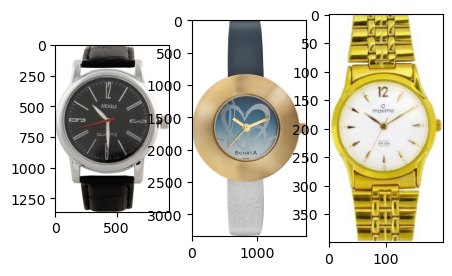

In [47]:
for name in list_labels:
    # Creating a figure
    plt.figure(figsize=(5, 5))
    print(name)

    # Displaying three sample images for each category
    for i in range(3):
        plt.subplot(130 + 1 + i)

        # Constructing the filepath
        filename = os.path.join(path, list_products_by_category(name)[i + 42])

        # Reading the image
        image = imread(filename)

        # Displaying the image
        plt.imshow(image)

    plt.show()

In [60]:
# Creating  'list_photos' by extracting the 'image' column from the DataFrame df
list_photos = df['image'].to_list()

In [61]:
# Creating a new path for modified images
path_pro = 'Images_b/'

In [62]:
dir_read = path
dir_write = path_pro

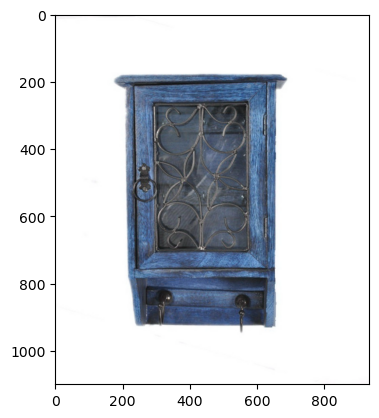

In [63]:
image_name = df['image'].loc[80]
dir_name = path
file_path = os.path.join(dir_name, image_name)

# Reading the file
image = cv2.imread(file_path)

# Displaying image
plt.imshow(image);

## Preprocessing
### Traitement des images

In [64]:
import time
from PIL import Image, ImageOps, ImageFilter, ImageEnhance

In [65]:
# Start the timer
temps1 = time.time()

# Setting the images sizes
new_width = 250
new_height = 250

# Image modifications for each product in the df
for index, row in df.iterrows():

    # get url of the product's image
    img_name = row['image']

    # create the path to the image file
    img_path = os.path.join(dir_read, img_name)

    # Read the file as a PIL Image
    img = Image.open(img_path)

    # Resizing the images
    img_resized = img.resize((new_width, new_height))

    # Converting the image to grayscale
    grayscale_image = img_resized.convert('L')

    # Equalizing
    equalized_image = ImageOps.equalize(grayscale_image)

    # Noise filtration
    blurred_image = equalized_image.filter(ImageFilter.GaussianBlur(radius=2))

    # Adjusting contrast
    contrast_enhancer = ImageEnhance.Contrast(blurred_image)
    contrast_enhanced_image = contrast_enhancer.enhance(1.5)

    # Save the preprocessed image
    img_preprocessed_path = os.path.join(dir_write, img_name)
    contrast_enhanced_image.save(img_preprocessed_path)

# Calculate the processing time
duration1 = time.time() - temps1
print("Processing time: ", "%15.2f" % duration1, "seconds")

Processing time:            76.96 seconds


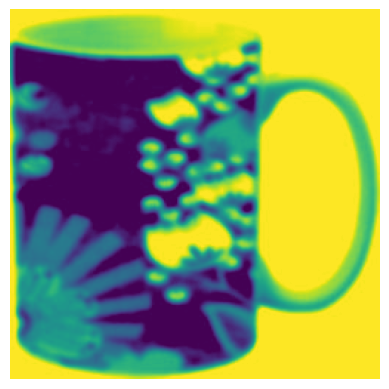

In [66]:
# Selecting an image to display
row_185 = df.iloc[185]

# Retrieving the image
image_name = row_185['image']

# Constructing the path to the preprocessed image
preprocessed_image_path = os.path.join(dir_write, image_name)

# Read and display the preprocessed image
preprocessed_image = Image.open(preprocessed_image_path)
plt.imshow(preprocessed_image)
plt.axis('off')
plt.show()

In [67]:
# Path to the directory containing preprocessed images
preprocessed_images_dir = dir_write

# Creating an array to store descriptors
descriptors_array = []

# Creating a SIFT object
sift = cv2.SIFT_create(500)

# Start the timer
temps2 = time.time()

# Iterating over each image in the directory
for img_name in os.listdir(preprocessed_images_dir):
    image_path = os.path.join(preprocessed_images_dir, img_name)
    img = Image.open(image_path)

    # Converting PIL Image to OpenCV format
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    # Detecting keypoints and computing descriptors
    keypoints, descriptors = sift.detectAndCompute(img_cv, None)

    # Append descriptors to the array
    descriptors_array.append(descriptors)

# Concatenate all descriptors into a single array
descriptors_all = np.concatenate(descriptors_array, axis=0)

# Calculate the processing time
duration2 = time.time() - temps2
print("Processing time: ", "%15.2f" % duration1, "seconds")

Processing time:            76.96 seconds


In [74]:
len(descriptors_array)

1050

In [75]:
descriptors_all.shape

(171364, 128)

### K-means

In [78]:
from sklearn import cluster

In [79]:
k = len(list_labels)

print(f"Number of estimated clusters: {k}")

# Clustering all descriptors
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(descriptors_all)

Number of estimated clusters: 7


MiniBatchKMeans(init_size=21, n_clusters=7, random_state=0)

In [80]:
# Function to build histogram for an image
def build_histogram(kmeans, descriptors, img_name):
    res = kmeans.predict(descriptors)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(descriptors)
    if nb_des == 0:
        print("Image histogram problem: ", img_name)
    for i in res:
        hist[i] += 1.0 / nb_des
    return hist

# Creating a histogram matrix
hist_vectors = []

# Iterating over the descriptors for each image
for i, image_desc in enumerate(descriptors_array):
    if i % 100 == 0:
        print(i)
    hist = build_histogram(kmeans, image_desc, i)  # Calculating the histogram
    hist_vectors.append(hist)  # Adding histogram to the list of histogram vectors

# Converting the list of histogram vectors to an array
im_features = np.asarray(hist_vectors)


0
100
200
300
400
500
600
700
800
900
1000


### PCA

In [85]:
from sklearn import decomposition
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics

In [83]:
# Printing the dimensions of the dataset before PCA reduction
print("Dataset dimensions before PCA reduction: ", im_features.shape)

# Performing the PCA
pca = decomposition.PCA(n_components = 0.99)
feat_pca = pca.fit_transform(im_features)

# Printing the dimensions of the dataset after PCA reduction
print("Dataset dimensions after PCA reduction: ", feat_pca.shape)

Dataset dimensions before PCA reduction:  (1050, 7)
Dataset dimensions after PCA reduction:  (1050, 6)


### T-sne

In [86]:
tsne = manifold.TSNE(n_components = 2, perplexity = 30, n_iter = 2000, init='random', random_state = 6)
X_tsne = tsne.fit_transform(feat_pca)

# Creatinf a new df for 2D visualisation
df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["category"]

# Printing the shape of the new df
print(df_tsne.shape)

(1050, 3)


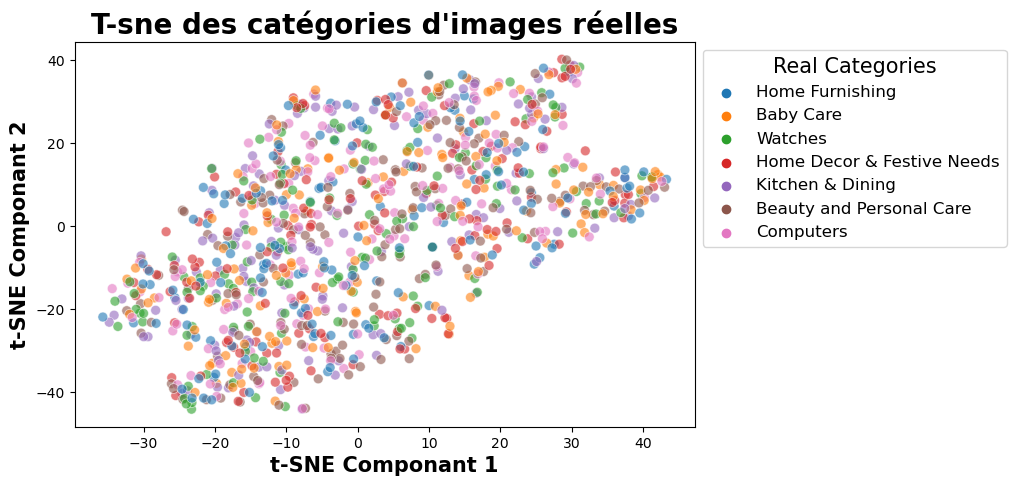

In [88]:
# Plotting the scatterplot
plt.figure(figsize=(8, 5))

sns.scatterplot(
    x = "tsne1", y = "tsne2", hue = "class", data = df_tsne, legend = "brief",
    palette=sns.color_palette('tab10', n_colors = 7), s = 50, alpha = 0.6)

# Setting the details
plt.title("T-sne des catégories d'images réelles", fontsize = 20, fontweight = 'bold')
plt.xlabel('t-SNE Componant 1', fontsize=15, fontweight='bold')
plt.ylabel('t-SNE Componant 2', fontsize=15, fontweight='bold')
plt.legend(fontsize = 12, loc='upper left', bbox_to_anchor=(1, 1), title = 'Real Categories', title_fontsize = 15)

# Displaying the plot
plt.show()

#### Kmeans sur les résultats t-SNE

In [89]:
# Performing the K-means clustering
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

# Adding the cluster labels to the DataFrame
df_tsne["cluster"] = cls.labels_

# Printing the shape of the DataFrame
print(df_tsne.shape)

(1050, 4)


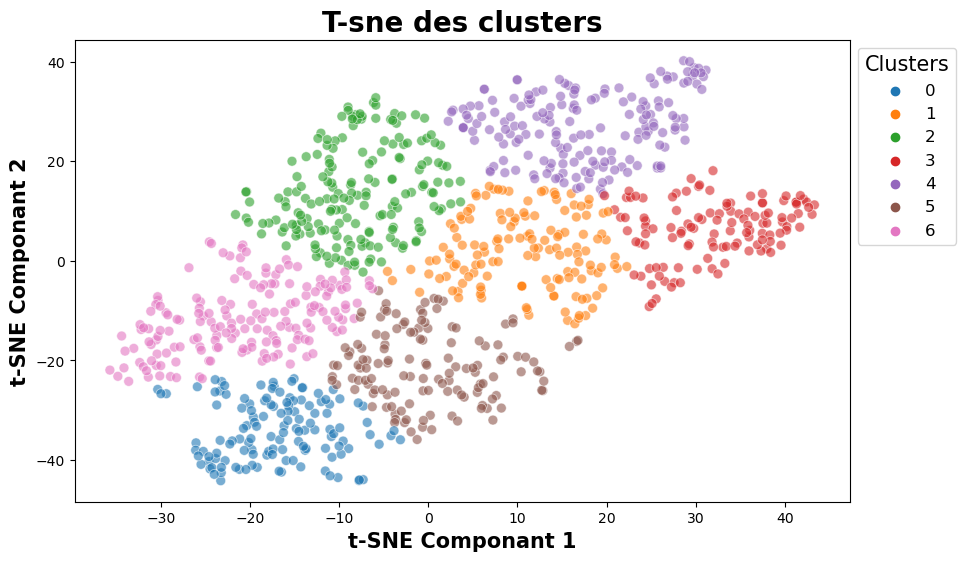

In [91]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

# Setting the details
plt.title('T-sne des clusters', fontsize=20, fontweight='bold')
plt.xlabel('t-SNE Componant 1', fontsize=15, fontweight='bold')
plt.ylabel('t-SNE Componant 2', fontsize=15, fontweight='bold')
plt.legend(fontsize = 12, loc='upper left', bbox_to_anchor=(1, 1), title = 'Clusters', title_fontsize = 15)

# Displaying the plot
plt.show()

In [92]:
# Calculate Adjusted Rand Index (ARI)
labels = df["category_encoded"]
ari = metrics.adjusted_rand_score(labels, cls.labels_)
print("ARI: ", ari)

ARI:  -0.0003226667762712493


### Classification avec CNN

In [109]:
from tensorflow.keras import layers
import random

In [96]:
# Loading the CNN model

img_height = 224
img_width = 224
num_classes = len(list_labels)

scratch_model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

scratch_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [103]:
df_samp = df.sample(500)

### non supervisé

In [104]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

image_path_cnn = 'Images/'

# Extract features from the images
def extract_features(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)  # Use preprocess_input from tensorflow.keras.applications.vgg16
    features = vgg_model.predict(img)
    return features.flatten()

# Extract features from the images in your dataset
image_features = []
for image_filename in df_samp['image']:
    image_path = os.path.join(image_path_cnn, image_filename)
    features = extract_features(image_path)
    image_features.append(features)


1/1 [==============================] - 1s 974ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


In [105]:
# Converting the features list to an array
image_features = np.array(image_features)

# Performing a t-SNE to visualize the extracted features
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(image_features)

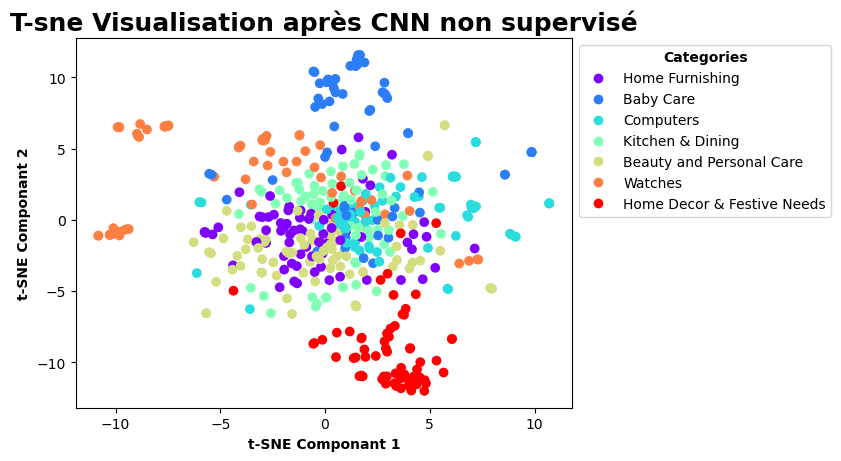

In [106]:
# Plot the t-SNE visualization
scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=df_samp['category_encoded'], cmap = 'rainbow')

# Adding legend based on the 'category' column
handles, labels = scatter.legend_elements()
legend = plt.legend(handles, df_samp['category'].unique(), title='Categories', bbox_to_anchor=(1,1), loc='upper left')
legend.get_title().set_fontweight('bold')

# Adding details
plt.title('T-sne Visualisation après CNN non supervisé', fontsize = 18, fontweight = 'bold')
plt.xlabel('t-SNE Componant 1', fontweight = 'bold')
plt.ylabel('t-SNE Componant 2', fontweight = 'bold')
plt.show()

In [ ]:
# Performing the K-means clustering
cls0 = cluster.KMeans(n_clusters=7, random_state=6)
cls0.fit(tsne_features)

# Adding the cluster labels to the DataFrame

df_tsne0["cluster2"] = cls0.labels_
# Printing the shape of the DataFrame
print(df_tsne0.shape)

### CNN supervisé

In [107]:
df_cnn = df[['image', 'category']]

In [110]:
# Setting a random seed
random.seed(42)

# Splitting the df to 80% training and 20% testing
ds_train, ds_test =  train_test_split(df_cnn, test_size=0.2)

In [111]:
# Categories or labels of product images
categories = ds_train.category.unique()
print(categories)

['Home Decor & Festive Needs' 'Kitchen & Dining' 'Computers'
 'Home Furnishing' 'Watches' 'Baby Care' 'Beauty and Personal Care']


In [112]:
# Creating lists of image filenames and corresponding product categories
keys = ds_train['image'].to_list()
values = ds_train['category'].to_list()

# Creating a dictionary to map image filenames to product categories
dict_images_labels = dict(map(lambda i, j: (i, j), keys, values))

In [115]:
import itertools

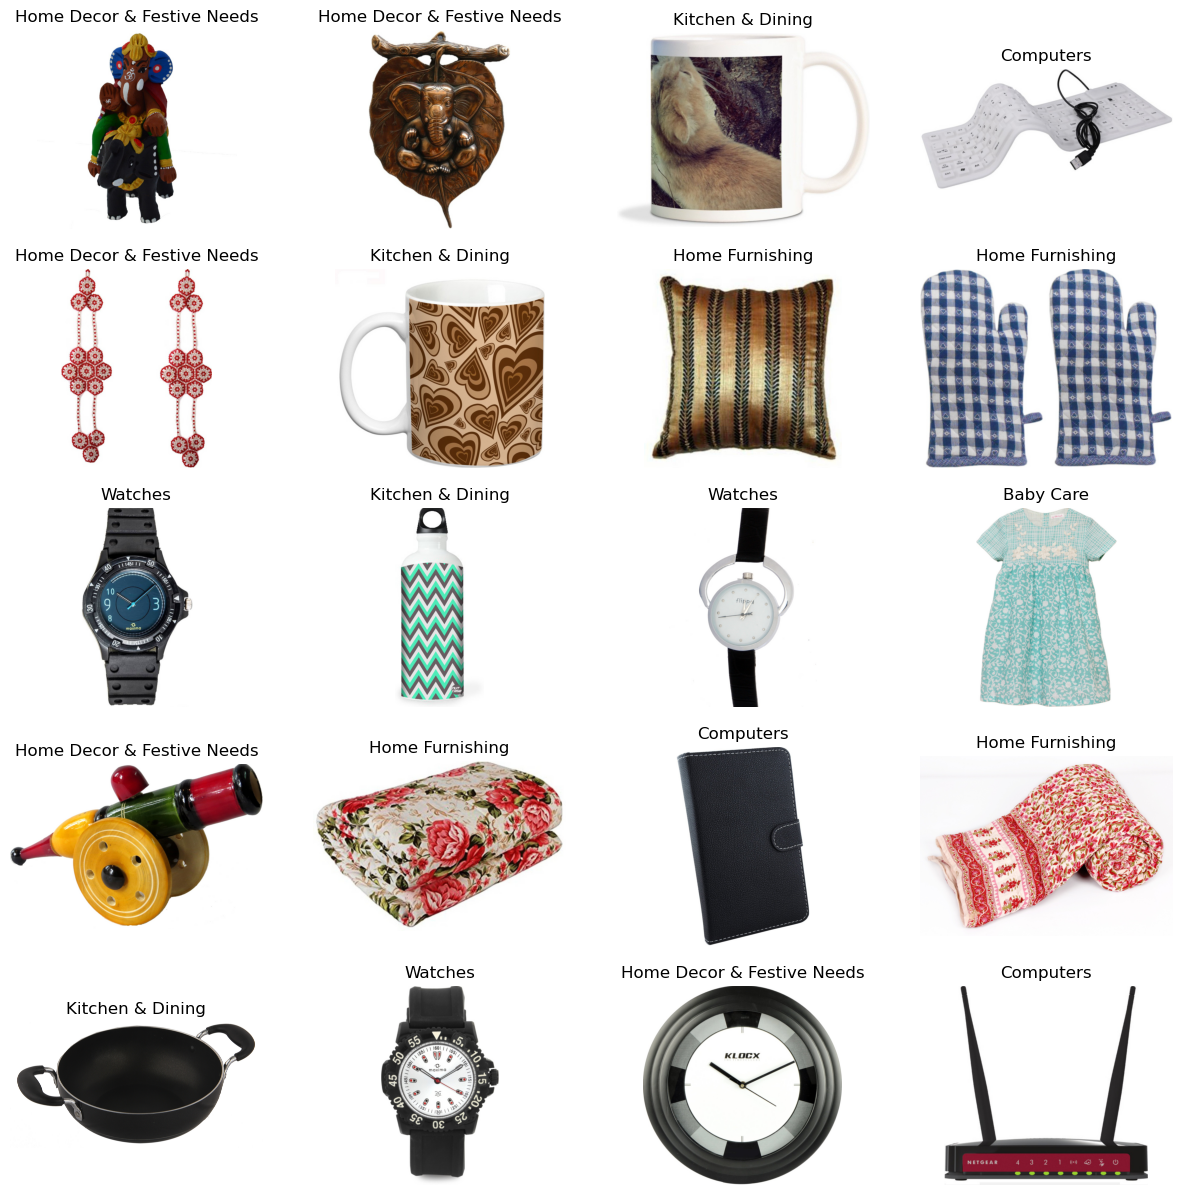

In [116]:
# Creating a figure of sample images
plt.figure(figsize=(15, 15))

# Creating a slice dictionary with 20 items from dict_images_labels
slice_dict = dict(itertools.islice(dict_images_labels.items(), 0, 20))

# Initializing a counter for the subplot index
i = 0

# Iterating over the items in slice_dict
for image, label in slice_dict.items():
    ax = plt.subplot(5, 4, i + 1)

    # Reading and displaying the image
    image_path = os.path.join(str(path), str(image))
    image = imread(image_path)
    plt.imshow(image)

    # Setting the details
    plt.title(label)
    plt.axis("off")

    # Incrementing the index
    i += 1

# SDisplaying the plot
plt.show()


In [117]:
# Création d'une série d'images pour chaque catégorie
images_Home_Furnishing = df[df['category'] == 'Home Furnishing']['image']
images_Baby_Care = df[df['category'] == 'Baby Care']['image']
images_Watches = df[df['category'] == 'Watches']['image']
images_Home_Decor_Festive_Needs = df[df['category'] == 'Home Decor & Festive Needs']['image']
images_Kitchen_Dining = df[df['category'] == 'Kitchen & Dining']['image']
images_Beauty_and_Personal_Care = df[df['category'] == 'Beauty and Personal Care']['image']
images_Computers = df[df['category'] == 'Computers']['image']

In [118]:
# Assigning the path of the directory where the labeled images will be stored
labeled_images = 'labeledImages/'

In [119]:
# Saving the 'category' Series as a CSV file with labeled images for each category
images_Home_Furnishing.to_csv(labeled_images + "Home_Furnishing.csv")
images_Baby_Care.to_csv(labeled_images + "Baby_Care.csv")
images_Beauty_and_Personal_Care.to_csv(labeled_images + "Beauty_and_Personal_Care.csv")
images_Computers.to_csv(labeled_images + "Computers.csv")
images_Home_Decor_Festive_Needs.to_csv(labeled_images + "Home_Decor_and_Festive_Needs.csv")
images_Kitchen_Dining.to_csv(labeled_images + "Kitchen_and_Dining.csv")
images_Watches.to_csv(labeled_images + "Watches.csv")

In [120]:
dict_categories_images = {"Home Furnishing": images_Home_Furnishing.to_list(),
                           "Baby Care": images_Baby_Care.to_list(),
                           "Beauty and Personal Care": images_Beauty_and_Personal_Care.to_list(),
                           "Computers": images_Computers.to_list(),
                           "Home Decor and Festive Needs": images_Home_Decor_Festive_Needs.to_list(),
                           "Kitchen and Dining": images_Kitchen_Dining.to_list(),
                           "Watches": images_Watches.to_list()}

In [123]:
#Sélection aléatoire de 30 % des images de la colonne "image" du premier DataFrame df
images_test = df['image'].sample(frac = 0.3, replace = True, random_state = 1).to_list()

In [124]:
# List of categories
list_folders_categories = ["Home Furnishing",
                           "Baby Care",
                           "Beauty and Personal Care",
                           "Computers",
                           "Home Decor and Festive Needs",
                           "Kitchen and Dining",
                           "Watches"]

In [128]:
import shutil
from shutil import SameFileError
import time

In [129]:
# Define the source and destination paths
src_all_images_path = 'Images/'
dest_root_label_path = 'training_label/'

# Get all images in the source directory
all_images_src = os.listdir(src_all_images_path)
print(f"Size of all images before removal of images for testing set: {len(all_images_src)}")

# Remove images that are in the testing set
all_images_src = [image for image in all_images_src if image not in images_test]
print(f"Size of all images after removal of images for testing set: {len(all_images_src)}")

print(f"The total number of images in the source folder: {len(all_images_src)}")

# Iterate over each category
for f_category in list_folders_categories:
    dest_all_images_category_path = os.path.join(dest_root_label_path, f_category)
    print("**************************")

    print(f"Category: {f_category}")
    print(f"Destination path: {dest_all_images_category_path}")

    # Iterate over images in the specific category
    for image_cat in dict_categories_images[f_category]:
        if image_cat in all_images_src:
            print(f"Name of image to copy: {image_cat}")

            # Construct source and destination file paths
            src_file = os.path.join(src_all_images_path, image_cat)
            dest_file = os.path.join(dest_all_images_category_path, image_cat)
            print(f"Image {image_cat} was copied to folder {dest_all_images_category_path}")

            try:
                # Copy the image to the destination folder
                shutil.copyfile(src_file, dest_file)
            except shutil.SameFileError:
                print("You are trying to copy the same file")
            except IsADirectoryError:
                print("The destination is a folder and not a file")

    print("**************************")


Size of all images before removal of images for testing set: 1050
Size of all images after removal of images for testing set: 788
The total number of images in the source folder: 788
**************************
Category: Home Furnishing
Destination path: training_label/Home Furnishing
Name of image to copy: 55b85ea15a1536d46b7190ad6fff8ce7.jpg
Image 55b85ea15a1536d46b7190ad6fff8ce7.jpg was copied to folder training_label/Home Furnishing


FileNotFoundError: [Errno 2] No such file or directory: 'training_label/Home Furnishing\\55b85ea15a1536d46b7190ad6fff8ce7.jpg'

In [130]:
print(f"The testing set has {len(images_test)} images")

The testing set has 315 images


In [131]:
categorized_images_sampled= df_cnn[df_cnn['image'].isin(images_test)]
categorized_images_sampled

,image,category
15,1120bc768623572513df956172ffefeb.jpg,Watches
20,d7ca2b06b4f4d3b98c61c377b18a2d6b.jpg,Watches
21,f74476ba64365d97a5be7d375cbf4c7a.jpg,Watches
24,653826cd53f1d9e2c086c0ac7846ef70.jpg,Watches
25,3c74db45cbfc14a78b8466dca494b3bb.jpg,Watches
...,...,...
1034,7815fb39feb773db944c9f03bbdcbf64.jpg,Computers
1039,3b96a152c8fac4421fb67b6190584976.jpg,Home Decor & Festive Needs
1042,057836ecde71565f8ebdd576e41fdc96.jpg,Baby Care
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care


In [132]:
categorized_images_sampled.groupby('category').count()

,image
category,
Baby Care,42
Beauty and Personal Care,30
Computers,36
Home Decor & Festive Needs,40
Home Furnishing,37
Kitchen & Dining,39
Watches,38
